In [1]:
import tensorflow as tf
from matplotlib import pyplot
import numpy as np
import os
import json

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory("data-150x150",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(150, 150),
  batch_size=32)

Found 79696 files belonging to 4 classes.
Using 63757 files for training.


In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory("data-150x150",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(150, 150),
  batch_size=32)

Found 79696 files belonging to 4 classes.
Using 15939 files for validation.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal", input_shape=(150,150,3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomCrop(120, 120) #height, width
  ]
)

In [6]:
num_classes = 4
models = {}

In [7]:
models["CNN"] = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [8]:
models["MLP"] = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Flatten(input_shape=(150, 150, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [9]:
for model in models.values():
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
for model in models.values():
    model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 120, 120, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 120, 120, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                  

In [11]:
epochs=100
histories = {}

In [12]:
for name in models:
    print("Training "+name+":")
    model_path = os.path.join("saved_models/", name+".h5")
    history_path = os.path.join("saved_histories", name+".json")
    histories[name] = models[name].fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
    )
    models[name].save(model_path)
    json.dump(histories[name].history, open(history_path, 'w'))
    print()

Training CNN:
Epoch 1/100
1993/1993 [==============================] - 65s 26ms/step - loss: 0.7087 - accuracy: 0.6991 - val_loss: 0.5035 - val_accuracy: 0.8074
Epoch 2/100
1993/1993 [==============================] - 45s 22ms/step - loss: 0.4046 - accuracy: 0.8482 - val_loss: 0.3662 - val_accuracy: 0.8644
Epoch 3/100
1993/1993 [==============================] - 46s 23ms/step - loss: 0.3274 - accuracy: 0.8796 - val_loss: 0.3588 - val_accuracy: 0.8677
Epoch 4/100
1993/1993 [==============================] - 45s 23ms/step - loss: 0.2892 - accuracy: 0.8951 - val_loss: 0.3415 - val_accuracy: 0.8689
Epoch 5/100
1993/1993 [==============================] - 46s 23ms/step - loss: 0.2666 - accuracy: 0.9037 - val_loss: 0.3130 - val_accuracy: 0.8887
Epoch 6/100
1993/1993 [==============================] - 45s 22ms/step - loss: 0.2519 - accuracy: 0.9097 - val_loss: 0.2770 - val_accuracy: 0.9026
Epoch 7/100
1993/1993 [==============================] - 47s 23ms/step - loss: 0.2414 - accuracy: 0.9135

1993/1993 [==============================] - 44s 22ms/step - loss: 0.1442 - accuracy: 0.9516 - val_loss: 0.2200 - val_accuracy: 0.9253
Epoch 57/100
1993/1993 [==============================] - 43s 22ms/step - loss: 0.1409 - accuracy: 0.9521 - val_loss: 0.2031 - val_accuracy: 0.9295
Epoch 58/100
1993/1993 [==============================] - 45s 23ms/step - loss: 0.1421 - accuracy: 0.9520 - val_loss: 0.1734 - val_accuracy: 0.9380
Epoch 59/100
1993/1993 [==============================] - 45s 23ms/step - loss: 0.1436 - accuracy: 0.9511 - val_loss: 0.1762 - val_accuracy: 0.9376
Epoch 60/100
1993/1993 [==============================] - 43s 22ms/step - loss: 0.1437 - accuracy: 0.9520 - val_loss: 0.1978 - val_accuracy: 0.9354
Epoch 61/100
1993/1993 [==============================] - 45s 23ms/step - loss: 0.1408 - accuracy: 0.9521 - val_loss: 0.1716 - val_accuracy: 0.9424
Epoch 62/100
1993/1993 [==============================] - 43s 22ms/step - loss: 0.1413 - accuracy: 0.9516 - val_loss: 0.1817 

1993/1993 [==============================] - 22s 11ms/step - loss: 1.3866 - accuracy: 0.2501 - val_loss: 1.3873 - val_accuracy: 0.2462
Epoch 12/100
1993/1993 [==============================] - 22s 11ms/step - loss: 1.3866 - accuracy: 0.2492 - val_loss: 1.3864 - val_accuracy: 0.2538
Epoch 13/100
1993/1993 [==============================] - 22s 11ms/step - loss: 1.4215 - accuracy: 0.2494 - val_loss: 1.3864 - val_accuracy: 0.2444
Epoch 14/100
1993/1993 [==============================] - 22s 11ms/step - loss: 1.3865 - accuracy: 0.2488 - val_loss: 1.3863 - val_accuracy: 0.2538
Epoch 15/100
1993/1993 [==============================] - 22s 11ms/step - loss: 1.3863 - accuracy: 0.2526 - val_loss: 1.3862 - val_accuracy: 0.2538
Epoch 16/100
1993/1993 [==============================] - 22s 11ms/step - loss: 1.3864 - accuracy: 0.2502 - val_loss: 1.3865 - val_accuracy: 0.2444
Epoch 17/100
1993/1993 [==============================] - 23s 11ms/step - loss: 1.3864 - accuracy: 0.2501 - val_loss: 1.3863 

1993/1993 [==============================] - 22s 11ms/step - loss: 1.3864 - accuracy: 0.2495 - val_loss: 1.3864 - val_accuracy: 0.2444
Epoch 67/100
1993/1993 [==============================] - 22s 11ms/step - loss: 1.3863 - accuracy: 0.2515 - val_loss: 1.3866 - val_accuracy: 0.2444
Epoch 68/100
1993/1993 [==============================] - 23s 12ms/step - loss: 1.3864 - accuracy: 0.2457 - val_loss: 1.3864 - val_accuracy: 0.2556
Epoch 69/100
1993/1993 [==============================] - 24s 12ms/step - loss: 1.3864 - accuracy: 0.2522 - val_loss: 1.3863 - val_accuracy: 0.2462
Epoch 70/100
1993/1993 [==============================] - 22s 11ms/step - loss: 1.3864 - accuracy: 0.2484 - val_loss: 1.3863 - val_accuracy: 0.2556
Epoch 71/100
1993/1993 [==============================] - 22s 11ms/step - loss: 1.3864 - accuracy: 0.2524 - val_loss: 1.3861 - val_accuracy: 0.2556
Epoch 72/100
1993/1993 [==============================] - 23s 11ms/step - loss: 1.3864 - accuracy: 0.2501 - val_loss: 1.3864 

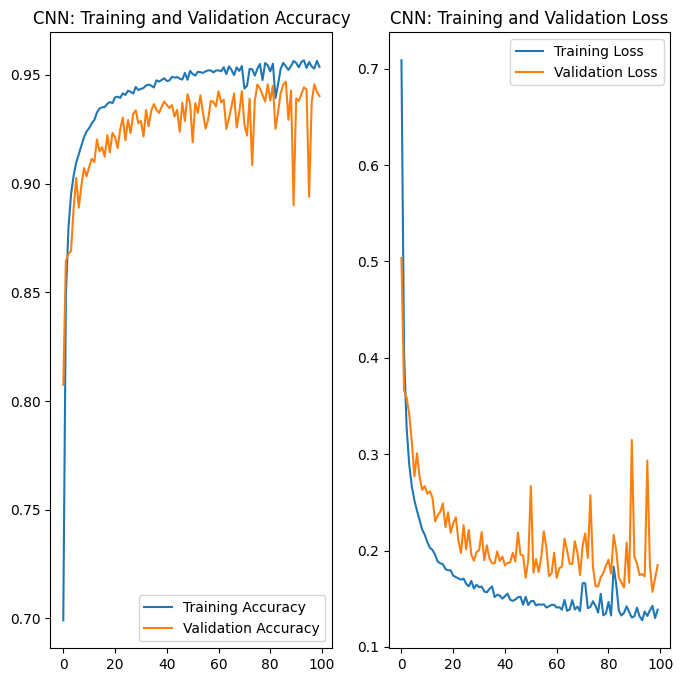

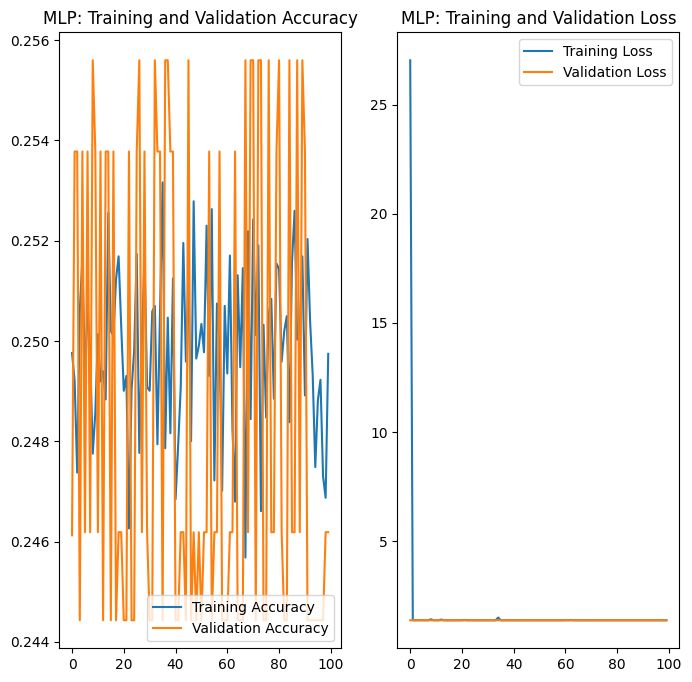

In [13]:
for name in histories:
    history = histories[name]
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    pyplot.figure(figsize=(8, 8))
    pyplot.subplot(1, 2, 1)
    pyplot.plot(epochs_range, acc, label='Training Accuracy')
    pyplot.plot(epochs_range, val_acc, label='Validation Accuracy')
    pyplot.legend(loc='lower right')
    pyplot.title(name+': Training and Validation Accuracy')

    pyplot.subplot(1, 2, 2)
    pyplot.plot(epochs_range, loss, label='Training Loss')
    pyplot.plot(epochs_range, val_loss, label='Validation Loss')
    pyplot.legend(loc='upper right')
    pyplot.title(name+': Training and Validation Loss')
    pyplot.show()

In [14]:
class_names = ["Wearing Mask a Correctly Over Mouth and Nose", "Wearing Mask a Over Mouth, but not Over Nose", "Not Wearing a Mask Over Mount and Nose", "Not Wearing a Mask"]

In [15]:
def predict(file_path):
    
    img = tf.keras.utils.load_img(file_path, target_size=(150, 150))
    pyplot.imshow(img)

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    for name in models:
        model = models[name]
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])


        print(
            "{} predicts {} ({:.2f}% confidence)"
            .format(name, class_names[np.argmax(score)], 100 * np.max(score))
        )
    pyplot.show()

CNN predicts Not Wearing a Mask (58.20% confidence)
MLP predicts Wearing Mask a Over Mouth, but not Over Nose (25.42% confidence)


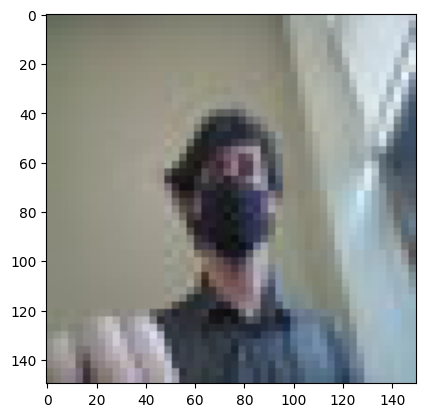

In [16]:
predict("faces/benjamin/1.jpg")

CNN predicts Not Wearing a Mask (55.29% confidence)
MLP predicts Wearing Mask a Over Mouth, but not Over Nose (25.42% confidence)


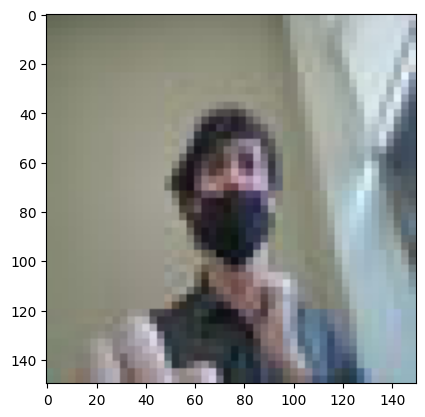

In [17]:
predict("faces/benjamin/2.jpg")

CNN predicts Not Wearing a Mask (52.51% confidence)
MLP predicts Wearing Mask a Over Mouth, but not Over Nose (25.42% confidence)


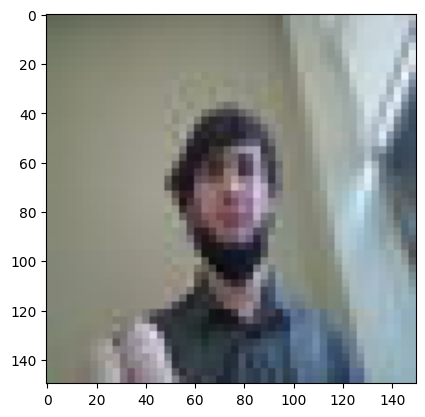

In [18]:
predict("faces/benjamin/3.jpg")

CNN predicts Not Wearing a Mask (82.29% confidence)
MLP predicts Wearing Mask a Over Mouth, but not Over Nose (25.42% confidence)


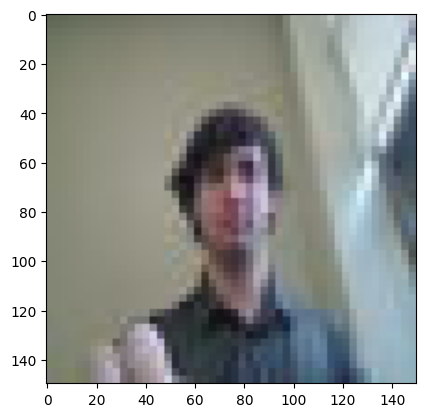

In [19]:
predict("faces/benjamin/4.jpg")

CNN predicts Wearing Mask a Correctly Over Mouth and Nose (94.73% confidence)
MLP predicts Wearing Mask a Over Mouth, but not Over Nose (25.42% confidence)


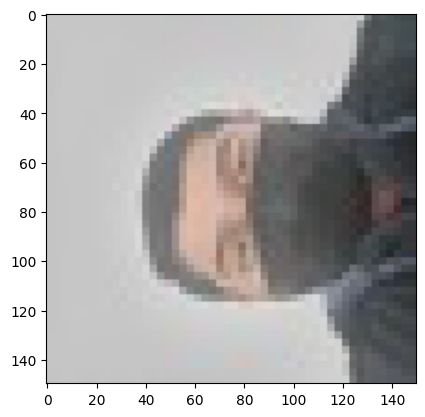

In [20]:
predict("faces/shaurya/1.jpg")

CNN predicts Wearing Mask a Over Mouth, but not Over Nose (99.07% confidence)
MLP predicts Wearing Mask a Over Mouth, but not Over Nose (25.42% confidence)


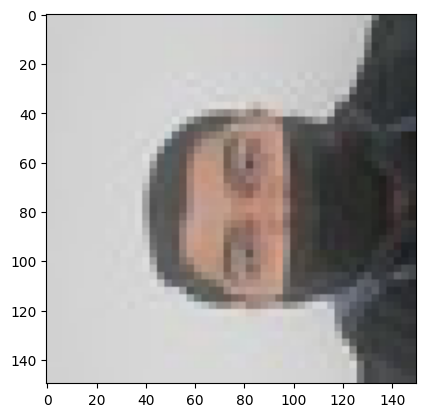

In [21]:
predict("faces/shaurya/2.jpg")

CNN predicts Not Wearing a Mask (94.03% confidence)
MLP predicts Wearing Mask a Over Mouth, but not Over Nose (25.42% confidence)


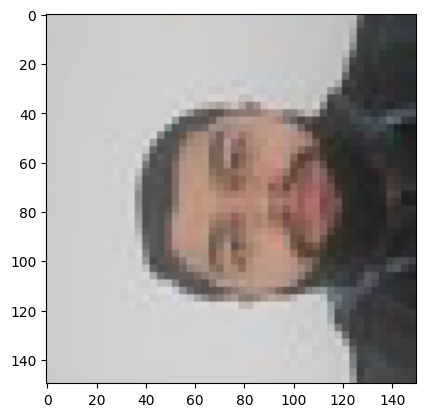

In [22]:
predict("faces/shaurya/3.jpg")

CNN predicts Not Wearing a Mask (92.10% confidence)
MLP predicts Wearing Mask a Over Mouth, but not Over Nose (25.42% confidence)


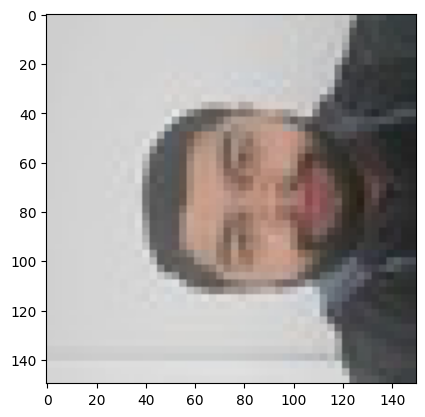

In [23]:
predict("faces/shaurya/4.jpg")

CNN predicts Wearing Mask a Correctly Over Mouth and Nose (98.76% confidence)
MLP predicts Wearing Mask a Over Mouth, but not Over Nose (25.42% confidence)


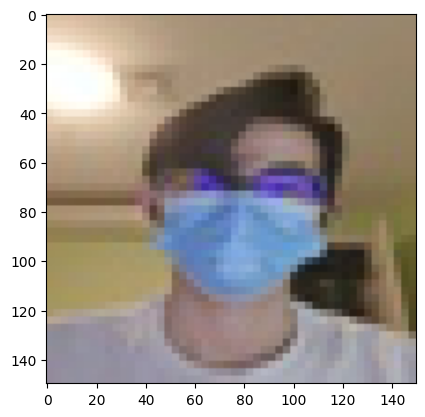

In [24]:
predict("faces/zunyi/1.jpg")

CNN predicts Wearing Mask a Over Mouth, but not Over Nose (99.51% confidence)
MLP predicts Wearing Mask a Over Mouth, but not Over Nose (25.42% confidence)


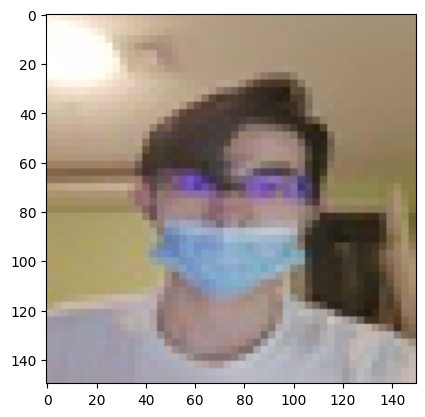

In [25]:
predict("faces/zunyi/2.jpg")

CNN predicts Not Wearing a Mask Over Mount and Nose (97.71% confidence)
MLP predicts Wearing Mask a Over Mouth, but not Over Nose (25.42% confidence)


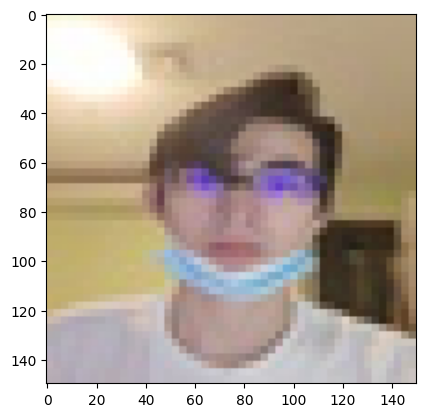

In [26]:
predict("faces/zunyi/3.jpg")

CNN predicts Not Wearing a Mask (74.85% confidence)
MLP predicts Wearing Mask a Over Mouth, but not Over Nose (25.42% confidence)


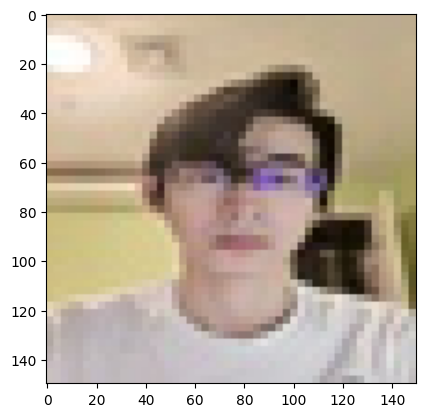

In [27]:
predict("faces/zunyi/4.jpg")

CNN predicts Not Wearing a Mask (44.02% confidence)
MLP predicts Wearing Mask a Over Mouth, but not Over Nose (25.42% confidence)


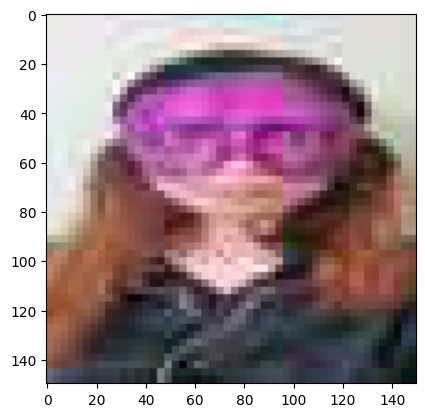

In [28]:
predict("faces/parisa/1.jpg")

CNN predicts Not Wearing a Mask (79.23% confidence)
MLP predicts Wearing Mask a Over Mouth, but not Over Nose (25.42% confidence)


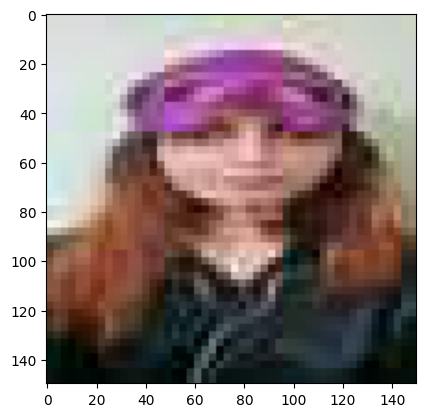

In [29]:
predict("faces/parisa/2.jpg")

CNN predicts Wearing Mask a Correctly Over Mouth and Nose (97.66% confidence)
MLP predicts Wearing Mask a Over Mouth, but not Over Nose (25.42% confidence)


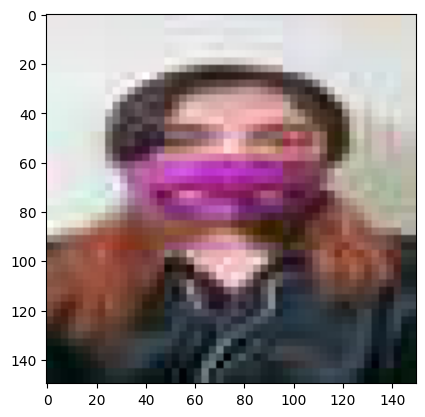

In [30]:
predict("faces/parisa/3.jpg")

## Source: https://www.tensorflow.org/tutorials/images/classification